In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate
import warnings
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Continuous
from sklearn.metrics import make_scorer
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split,  cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, ElasticNet
import time
import sys, os
from sklearn.pipeline import make_pipeline


path = 'datasets/Dataset_2.xlsx'

# Read and load dataset
df= pd.read_excel(path, sheet_name="preproc")




INPUT DATA

In [14]:
X = (df.iloc[:,14:]).values
print(X.shape)
std_scaler = StandardScaler()

(2905, 530)


OUTPUT DATA

In [15]:
Y = (df.iloc[:,7]).values
print(Y.shape)

(2905,)


**NRMSEPiqr**

In [16]:


def NRMSEPiqr(observed_values, predicted_values):
    # Calculate RMSEP
    rmsep = np.sqrt(np.mean((observed_values - predicted_values) ** 2))
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = np.percentile(observed_values, 25)
    Q3 = np.percentile(observed_values, 75)

    # Calculate IQR
    IQR = Q3 - Q1

    return rmsep/IQR

NRMSEPiqrscorer = make_scorer(NRMSEPiqr,greater_is_better=False)


RIDGE

In [ ]:

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" 

#number of trials
trials = 100
np.random.seed(42)
seeds = np.random.randint(trials, size=trials)

ripartisions = [0.25,0.5,0.75]
results = []  

# create 3x1 subfigs
fig, axs = plt.subplots(3, 1,figsize=(20, 25),gridspec_kw={'hspace': 0.5})
fig.suptitle('Ridge K-fold NITROGEN NRMSEPiqr test'+"\n")
axs = axs.flatten()
k = 0

for ripartition in ripartisions:

    NRMSEP = []

    best_NRMSEP = 100000000
    best_data_1 = {"Y_test":None, "Y_pred":None,"alpha":None,"seed":None}

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=ripartition, random_state=42) 
    param_grid = {'ridge__alpha': Continuous(1/100000,0.01)}
    ridge_pipeline = make_pipeline(StandardScaler(), Ridge(solver="cholesky"))
    sturges = int(1 + np.log(len(X_train)))    
    evolved_estimator = GASearchCV(estimator=ridge_pipeline,
                                  cv=sturges,
                                  scoring=NRMSEPiqrscorer,
                                  param_grid=param_grid,
                                  n_jobs=-1,
                                  verbose=True,
                                  population_size=50,
                                  generations=100,
                                  criteria = "min")
    

    start_time = time.time()
    evolved_estimator.fit(X_train, Y_train)
    elapsed_time = (time.time() -start_time) #elapsed time in seconds

    print("Best vaue of alpha: ", str(evolved_estimator.best_params_["ridge__alpha"]))

    best_model =  evolved_estimator.best_estimator_
    cv_scores = cross_validate(best_model, X_train, Y_train, cv=sturges, scoring=NRMSEPiqrscorer,n_jobs=-1)      
    Y_pred_ridge_cl = best_model.predict(X_test)

    results.append([str(ripartition *100 ),-np.mean(cv_scores['test_score']), np.var(cv_scores['test_score']),
                    np.mean(cv_scores['fit_time']), elapsed_time, NRMSEPiqr(Y_test, Y_pred_ridge_cl),float(evolved_estimator.best_params_["ridge__alpha"])])

    # Display results
    print("Cross-validation NRMSEPiqr scores:", cv_scores['test_score'])
    print("Training times (seconds):", cv_scores['fit_time'])
    print("Scoring times (seconds):", cv_scores['score_time'])
    print("Final training time (seconds):", elapsed_time)
    print("Final NRMSEPiqr: ",  NRMSEPiqr(Y_test, Y_pred_ridge_cl))


           
    '''PLOT THE FINAL MODELS'''
    axs[k].scatter(Y_test, Y_pred_ridge_cl, c='blue', label='Actual vs Predicted')
    axs[k].plot([min(Y_test), max(Y_test)],
                    [min(Y_test), max(Y_test)], '--', c='red', label='Perfect Prediction')
    axs[k].legend()
    axs[k].set_xlabel("Actual values")
    axs[k].set_ylabel("Predicted value")
    axs[k].set_title( f"Test size(%): {ripartition * 100}" "\n" + "FINAL NRMSEPiqr: " + str(NRMSEPiqr(Y_test, Y_pred_ridge_cl) ))
    k += 1


'''SHOW RESULTS'''

headers = ["Test size(%)", "Mean CV NRMSEPiqr", "Var CV NRMSEPiqr)","Mean CV Training Time (sec)" ,"Final training time (sec)","Final NRMSEPiqr","alpha"]
print(tabulate(results, headers,  tablefmt="double_outline"))

gen	nevals	fitness  	fitness_std	fitness_max	fitness_min
0  	50    	-0.292175	0.00198566 	-0.289374  	-0.295508  
1  	100   	-0.293717	0.00154609 	-0.290541  	-0.295501  
2  	100   	-0.294549	0.00106338 	-0.29037   	-0.295501  
3  	100   	-0.294719	0.00101704 	-0.290457  	-0.295547  
4  	100   	-0.295041	0.000696615	-0.291439  	-0.295547  
5  	100   	-0.29527 	0.000377676	-0.293787  	-0.295547  


LASSO

In [ ]:

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" 

#number of trials
trials = 100
np.random.seed(42)
seeds = np.random.randint(trials, size=trials)

ripartisions = [0.25,0.5,0.75]
results = []  

# create 3x1 subfigs
fig, axs = plt.subplots(3, 1,figsize=(20, 25),gridspec_kw={'hspace': 0.5})
fig.suptitle('Lasso K-fold NITROGEN NRMSEPiqr test'+"\n")
axs = axs.flatten()
k = 0

for ripartition in ripartisions:

    NRMSEP = []

    best_NRMSEP = 100000000
    best_data_1 = {"Y_test":None, "Y_pred":None,"alpha":None,"seed":None}

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=ripartition, random_state=42) 
    param_grid = {'lasso__alpha': Continuous(1/100000,0.01)}
    lasso_pipeline = make_pipeline(StandardScaler(),  Lasso(max_iter=5000, tol=1e-2))
    sturges = int(1 + np.log(len(X_train)))    
    evolved_estimator = GASearchCV(estimator=lasso_pipeline,
                                  cv=sturges,
                                  scoring=NRMSEPiqrscorer,
                                  param_grid=param_grid,
                                  n_jobs=-1,
                                  verbose=True,
                                  population_size=50,
                                  generations=100,
                                  criteria = "min")
    

    start_time = time.time()
    evolved_estimator.fit(X_train, Y_train)
    elapsed_time = (time.time() -start_time) #elapsed time in seconds

    print("Best vaue of alpha: ", str(evolved_estimator.best_params_["lasso__alpha"]))

    best_model =  evolved_estimator.best_estimator_
    cv_scores = cross_validate(best_model, X_train, Y_train, cv=sturges, scoring=NRMSEPiqrscorer,n_jobs=-1)      
    Y_pred_lasso_cd = best_model.predict(X_test)


    results.append([str(ripartition *100 ),-np.mean(cv_scores['test_score']), np.var(cv_scores['test_score']),
                    np.mean(cv_scores['fit_time']), elapsed_time, NRMSEPiqr(Y_test, Y_pred_lasso_cd),float(evolved_estimator.best_params_["lasso__alpha"])])



    # Display results
    print("Cross-validation NRMSEPiqr scores:", cv_scores['test_score'])
    print("Training times (seconds):", cv_scores['fit_time'])
    print("Scoring times (seconds):", cv_scores['score_time'])
    print("Final training time (seconds):", elapsed_time)
    print("Final NRMSEPiqr: ",  NRMSEPiqr(Y_test, Y_pred_lasso_cd))


           
    '''PLOT THE FINAL MODELS'''
    axs[k].scatter(Y_test, Y_pred_lasso_cd, c='blue', label='Actual vs Predicted')
    axs[k].plot([min(Y_test), max(Y_test)],
                    [min(Y_test), max(Y_test)], '--', c='red', label='Perfect Prediction')
    axs[k].legend()
    axs[k].set_xlabel("Actual values")
    axs[k].set_ylabel("Predicted value")
    axs[k].set_title( f"Test size(%): {ripartition * 100}" "\n" + "FINAL NRMSEPiqr: " + str(NRMSEPiqr(Y_test, Y_pred_lasso_cd) ))
    k += 1

'''SHOW RESULTS'''

headers = ["Test size(%)", "Mean CV NRMSEPiqr", "Var CV NRMSEPiqr)","Mean CV Training Time (sec)" ,"Final training time (sec)","Final NRMSEPiqr","alpha"]
print(tabulate(results, headers,  tablefmt="double_outline"))



Elastic Net

KeyboardInterrupt: 

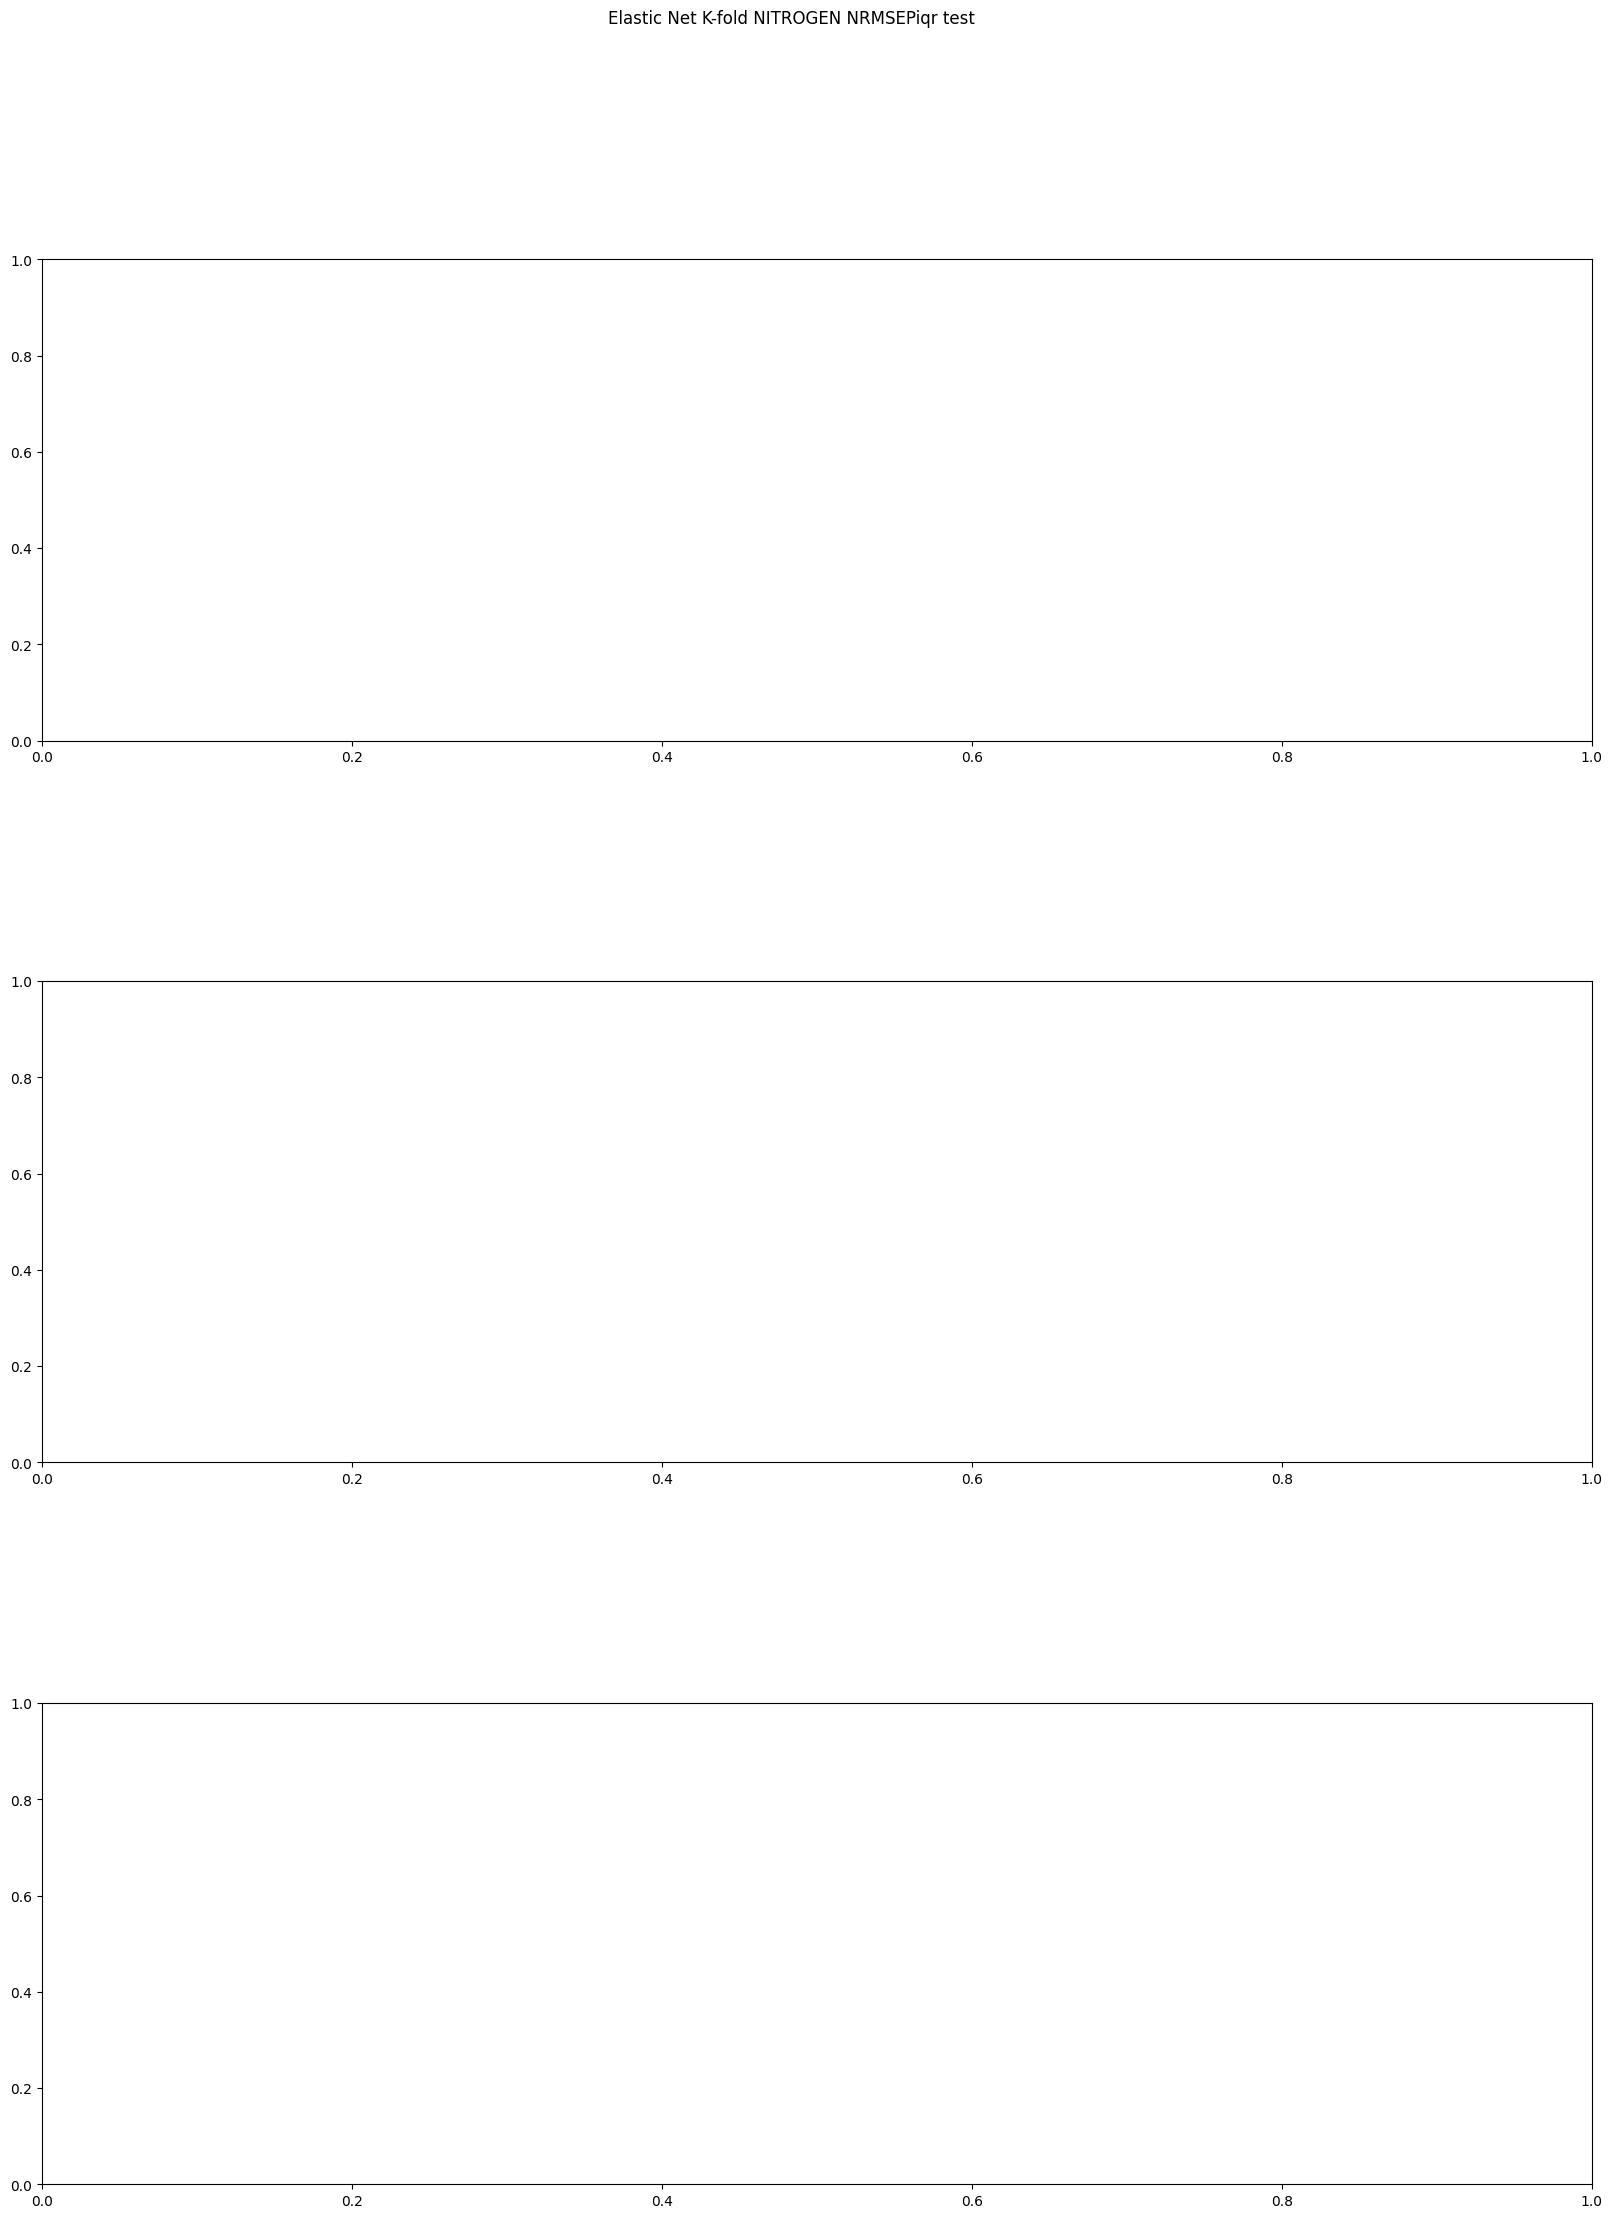

In [12]:

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" 

#number of trials
trials = 100
np.random.seed(42)
seeds = np.random.randint(trials, size=trials)

ripartisions = [0.25,0.5,0.75]
results = []  

# create 3x1 subfigs
fig, axs = plt.subplots(3, 1,figsize=(20, 25),gridspec_kw={'hspace': 0.5})
fig.suptitle('Elastic Net K-fold NITROGEN NRMSEPiqr test'+"\n")
axs = axs.flatten()
k = 0

for ripartition in ripartisions:

    NRMSEP = []

    best_NRMSEP = 100000000
    best_data_1 = {"Y_test":None, "Y_pred":None,"alpha":None,"seed":None}

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=ripartition, random_state=42) 
    param_grid = {'elasticnet__alpha': Continuous(1/100000,0.01),"elasticnet__l1_ratio":Continuous(0,1)}
    lasso_pipeline = make_pipeline(StandardScaler(),  ElasticNet(max_iter=5000, tol=1e-2))
    sturges = int(1 + np.log(len(X_train)))    
    evolved_estimator = GASearchCV(estimator=lasso_pipeline,
                                  cv=sturges,
                                  scoring=NRMSEPiqrscorer,
                                  param_grid=param_grid,
                                  n_jobs=-1,
                                  verbose=True,
                                  population_size=50,
                                  generations=100,
                                  criteria = "min")
    

    start_time = time.time()
    evolved_estimator.fit(X_train, Y_train)
    elapsed_time = (time.time() -start_time) #elapsed time in seconds

    print("Best vaue of alpha: ", str(evolved_estimator.best_params_["elasticnet__alpha"]))

    best_model =  evolved_estimator.best_estimator_
    cv_scores = cross_validate(best_model, X_train, Y_train, cv=sturges, scoring=NRMSEPiqrscorer,n_jobs=-1)      
    Y_pred_ridge_cl = best_model.predict(X_test)

    results.append([str(ripartition *100 ),-np.mean(cv_scores['test_score']), np.var(cv_scores['test_score']),
                    np.mean(cv_scores['fit_time']), elapsed_time, NRMSEPiqr(Y_test, Y_pred_lasso_cd),float(evolved_estimator.best_params_["elasticnet__alpha"]),float(evolved_estimator.best_params_["elasticnet__l1_ratio"])])

    # Display results
    print("Cross-validation NRMSEPiqr scores:", cv_scores['test_score'])
    print("Training times (seconds):", cv_scores['fit_time'])
    print("Scoring times (seconds):", cv_scores['score_time'])
    print("Final training time (seconds):", elapsed_time)
    print("Final NRMSEPiqr: ",  NRMSEPiqr(Y_test, Y_pred_ridge_cl))


           
    '''PLOT THE FINAL MODELS'''
    axs[k].scatter(Y_test, Y_pred_ridge_cl, c='blue', label='Actual vs Predicted')
    axs[k].plot([min(Y_test), max(Y_test)],
                    [min(Y_test), max(Y_test)], '--', c='red', label='Perfect Prediction')
    axs[k].legend()
    axs[k].set_xlabel("Actual values")
    axs[k].set_ylabel("Predicted value")
    axs[k].set_title( f"Test size(%): {ripartition * 100}" "\n" + "FINAL NRMSEPiqr: " + str(NRMSEPiqr(Y_test, Y_pred_ridge_cl)))
    k += 1

'''SHOW RESULTS'''

headers = ["Test size(%)", "Mean CV NRMSEPiqr", "Var CV NRMSEPiqr)","Mean CV Training Time (sec)" ,"Final training time (sec)","Final NRMSEPiqr","alpha","r"]
print(tabulate(results, headers,  tablefmt="double_outline"))
